In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time
import sys
import random

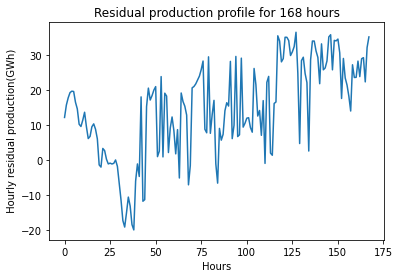

In [6]:
# On fixe le nombre d'heures étudiées pour réduire la taille du problème
h = 168 #une semaine

#Hourly electricity production in 2016 (reference year)
resultats_2016 = pd.read_csv("Données/hourly profiles with demand of 2016.csv")
resultats_2016 = resultats_2016.to_numpy()

vre = pd.read_csv("Données/vre_profiles2006.csv")
vre = vre.to_numpy()

offshore = np.zeros((8760,2))
offshore[:,1] = resultats_2016[:,1]*vre[0:8760,2]
offshore[:,0] = resultats_2016[:,0]

onshore = np.zeros((8760,2))
onshore[:,1] = resultats_2016[:,2]*vre[8760:17520,2]
onshore[:,0] = resultats_2016[:,0]

PV = np.zeros((8760,2))
PV[:,1] = resultats_2016[:,3]*vre[17520:26280,2]
PV[:,0] = resultats_2016[:,0]

river = np.zeros((8760,2))
river[:,1] = resultats_2016[:,4] #*vre[26280:35040,2]
river[:,0] = resultats_2016[:,0]

lake = np.zeros((8760,2))
lake[:,1] = resultats_2016[:,5] #*vre[35040:43800,2]
lake[:,0] = resultats_2016[:,0]

biogas = np.zeros((8760,2))
biogas[:,1] = resultats_2016[:,6] #*vre[43800:52560,2]
biogas[:,0] = resultats_2016[:,0]

gas = np.zeros((8760,2))
gas[:,1] = resultats_2016[:,7] #*vre[52560:61320,2]
gas[:,0] = resultats_2016[:,0]

prodf = np.zeros((8760,2))
prodf[:,0] = resultats_2016[:,0]
prodf[:,1] = offshore[:,1] + onshore[:,1]+ PV[:,1] + river[:,1] + lake[:,1] + biogas[:,1] + gas[:,1] 

##Electricity demand in 2050 (Negawatt)
demande = pd.read_csv("Données/demand2050_negawatt.csv")  
demande = demande.to_numpy()

#Residual production
Production_res = np.zeros((8760,2))
Production_res[:,0] = np.copy(prodf[:,0])
Production_res[:,1] = prodf[:,1] - demande[:,1]

#Reduced problem
PR = np.zeros((h,2))
PR[:,0] = Production_res[0:h,0]
PR[:,1] = Production_res[0:h,1]

#Residual production profile
plt.plot(PR[:,1])
plt.title("Residual production profile for %d hours"%h)
plt.xlabel('Hours')
plt.ylabel(' Hourly residual production(GWh)')
plt.show()

In [7]:
#Cost /technology
a = 1.4 #25.805  #phs
b = 87.9481 #methanation

#stock maximal pour chaque technologie
xmax = 180   #valeur pour l'année 2006 (page 34, table 1.2 appendix 3) #phs
ymax = 500 #7740 #methanation

#contrainte par rapport aux flux entrants et sortant
Rb = 15 #6.2 #flux max entrant
Db = 15 #7.2
Rm = 300 #8
Dm = 200 #15  ### valeurs ????
#Nous n'avons pas trouvé de valeurs concernant Rm, Dm

In [8]:
def proxC(U1,g,a,b,h): #prox de c (fonction coût)
    prox = np.zeros_like(U1)
    prox[:h] = np.sign(U1[:h])*np.maximum(np.abs(U1[:h])-np.ones(len(U1[:h]))*g*a, np.zeros(len(U1[:h])))
    prox[h:] = np.sign(U1[h:])*np.maximum(np.abs(U1[h:])-np.ones(len(U1[h:]))*g*b, np.zeros(len(U1[h:])))
    return prox

def proxP(U2, PR, h): #prox de p (projection sur la production résiduelle)
    #contrainte de production: (projection orthogonale)
    prox = np.copy(U2)
    for k in range(h):
        if U2[k]+U2[k+h] > PR[k]:
            prox[k] = (1/2)*(U2[k] + PR[k]-U2[k+h])
            prox[k+h] = PR[k] - (1/2)*(U2[k] + PR[k]-U2[k+h])
    return prox

def proxP2(U2, PR, h): #prox de p (projection sur la production résiduelle)
    #contrainte de production: (projection orthogonale)
    prox = np.copy(U2)
    for k in range(h):
        prox[k] = min(U2[k], (1/2)*(U2[k] + PR[k]-U2[k+h]))
        prox[k+h] = min(U2[k+h], (1/2)*(-U2[k] + PR[k]+U2[k+h]))
    return prox

def proxF(U3, Rb, Db, Rm, Dm, h): #prox de f (contrainte sur les flux)
    prox = np.copy(U3)
    #contrainte de flux: (boîte)
    
    prox[:h][np.where(prox[:h] > Rb)] = Rb
    prox[:h][np.where(prox[:h] < Db)] = Db
    
    prox[h:][np.where(prox[h:] > Rm)] = Rm
    prox[h:][np.where(prox[h:] < Dm)] = Dm
    
    return prox

def proxS2(Ui,xmax,ymax,h): #en un vecteur, une des 8760 contraintes sur la somme cumulative (max de stocks)
    proxS = np.copy(Ui)
    for k in range(h):
        XC = np.cumsum(proxS[:h])
        YC = np.cumsum(proxS[h:])
        if k==0:
            if XC[0]-xmax>0:
                proxS[0]-=XC[0]-xmax
            if YC[0]-ymax>0:
                proxS[h]-=YC[0]-ymax
        else:
            diff = (XC[k] - xmax)/(k+1)
            if diff>0:
                for i in range(k+1):
                    proxS[i]-=diff
            diff2 = (YC[k]-ymax)/(k+1)
            if diff2>0:
                for j in range(k+1):
                    proxS[j+h]-=diff
    return proxS

def proxS(Ui,xmax,ymax,h): #en un vecteur, une des 8760 contraintes sur la somme cumulative (max de stocks)
    prox = np.copy(Ui)
    
    if prox[0] > xmax:
        prox[0] -= prox[0] - xmax
    if prox[h] > ymax:
        prox[h] -= prox[h] - ymax
            
    for i in range(2,h+1):
        
        xcum = sum(prox[:i])
        #print("xcum = ", xcum)
        
            
        if xcum > xmax:
            diff = xcum - xmax
            #print("diffx = ", diff)
            h1 = diff/i
            #print("soustrait à x: ", h1)
            prox[:i] -= h1*np.ones(np.shape(Ui[:i])[0])
            
    for i in range(h+1,2*h):
        
        ycum = sum(prox[h:i+1])
        #print("ycum = ", ycum)
        if ycum > ymax:
            diff2 = ycum - ymax
            #print("diffy = ", diff2)
            h2 = diff2/(i-h+1)
            #print("soustrait à y: ", h2)
            prox[h:i+1] -= h2*np.ones(np.shape(Ui[h:i+1])[0])
            
    return prox
    
def proxD(U): #prox de l'indicatrice d'égalité de toutes les variables (h+3)
    prox = np.zeros_like(U)
    N = np.shape(U)[0]
    for k in range(N):
        prox[k,:] = np.mean(U[k,:])*np.ones(np.shape(U)[1])
    return prox
        
def proxg(U,g,a,b,Rb, Db, Rm,Dm,PR,xmax,ymax,h): #rassemblement de tous les prox 
    Res = np.copy(U)
    N1,N2 = np.shape(Res)
    Res[:,0] = proxC(U[:,0],g,a,b,h)
    Res[:,1] = proxP(U[:,1],PR,h)
    Res[:,2] = proxF(U[:,2], Rb,Db,Rm,Dm,h)
    for i in range(3, N2):
        Res[:,i] = proxS(U[:,i], xmax, ymax, h)
    return Res
             
def DR(X0,a,b,Rb, Db, Rm,Dm,PR,xmax,ymax,h, eps = 1e-5,g=1, itermax = 150): #algo de douglas rachford
    k = 0
    X = np.copy(X0)
    while k<itermax: 
        k+=1
        Yk = proxg(X,g,a,b,Rb, Db, Rm,Dm,PR,xmax,ymax,h)
        Zk = proxD(2*Yk-X)
        X = X + (0.5)*(Zk-Yk)
    return X

In [9]:
## Approche approximative pour avoir le pt de départ


In [10]:
X_0 = np.ones((2*h, h+3))
result = DR(X_0, a,b,Rb, Db, Rm,Dm, Production_res[:,1],xmax,ymax,h, g=1.5)

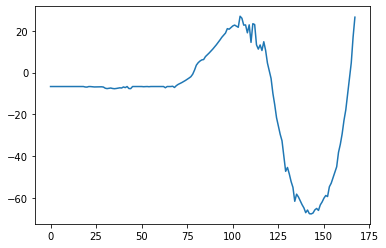

In [11]:
plt.plot(result[:h,0]) #flux barrages sur 168h

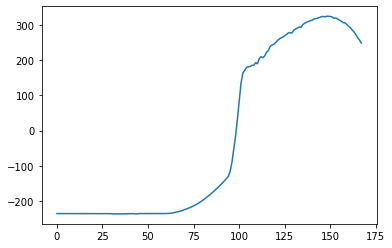

In [12]:
plt.plot(result[h:,0]) #méthanation

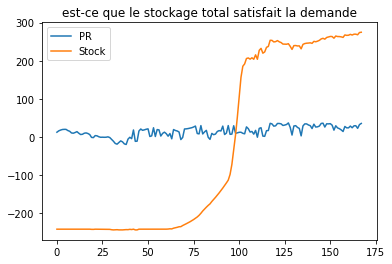

In [13]:
plt.plot(PR[:,1], label = "PR")
plt.plot(result[:h,0]+result[h:,0], label = "Stock")
plt.title("est-ce que le stockage total satisfait la demande")
plt.legend()
plt.show()

In [32]:
## TEST DES PROX ##

Utest = np.array([20.,10.,-2,6.,-5.,18.])

atest = 2 
btest = 5
gtest = 1
htest = 3

print("Résultat attendu : (18,8,0,1,0,13)") #seuillage doux de Uc par 2 (3 premiers élt) puis 5 (3 derniers)
print(proxC(Utest,gtest,atest,btest,htest))

Résultat attendu : (18,8,0,1,0,13)
[18.  8. -0.  1. -0. 13.]


In [33]:
PRtest = np.array([10,8,4])

print("Résultat attendu : (12,10,-8,-2,-5,12)")
print(proxP(Utest,PRtest,htest))

Résultat attendu : (12,10,-8,-2,-5,12)
[12. 10. -8. -2. -5. 12.]


In [34]:
print("Résultat attendu : (4.5, 4.5, -2, 4.5, -5, 4.5)")
Rbtest = 4.5
Dbtest = -5
Rmtest = 4.5
Dmtest = -5
print(proxF(Utest, Rbtest, Dbtest, Rmtest, Dmtest, htest))

Résultat attendu : (4.5, 4.5, -2, 4.5, -5, 4.5)
[ 4.5  4.5 -2.   4.5 -5.   4.5]


In [35]:
a = 13/3
print("Résultat attendu : (9, 5, -2,", 6-a, -5-a, 18-a, ")")
xlim = 14
ylim = 6
print(proxS(Utest, xlim,ylim, htest))

Résultat attendu : (9, 5, -2, 1.666666666666667 -9.333333333333332 13.666666666666668 )
[ 9.          5.         -2.          1.66666667 -9.33333333 13.66666667]


In [36]:
Ut = np.array([15.,9.,-8.,12.,2.,4.,16.,7.,-8.,10.])
print("Résultat attendu = (12.6, 6.6, -9.4, 10.6, 1.6, 1.27, 13.27, 4.27, -8.4, 9.6)")
xlim2 = 22
ylim2 = 20
htest2 = 5
print(proxS(Ut, xlim2,ylim2, htest2))

Résultat attendu = (12.6, 6.6, -9.4, 10.6, 1.6, 1.27, 13.27, 4.27, -8.4, 9.6)
[12.6         6.6        -9.4        10.6         1.6         1.26666667
 13.26666667  4.26666667 -8.4         9.6       ]


In [37]:
Ud = np.ones((2,3))
Ud[0,0] = 5
Ud[1,0] = 6
Ud[0,1] = 10
Ud[1,1] = -10
Ud[0,2] = -4
Ud[1,2] = 18
print("Résultat attendu : (3.6, 4.6)")
print(proxD(Ud))

Résultat attendu : (3.6, 4.6)
[[3.66666667 3.66666667 3.66666667]
 [4.66666667 4.66666667 4.66666667]]


In [38]:
Uc = np.array([5.,10.,-2,6.,-5.,18.])
print("ProxC = ", proxC(Uc,gtest,atest,btest,htest))
print("ProxP = ", proxP(Uc,PRtest,htest))
print("ProxF = ", proxF(Uc, Rbtest, Dbtest, Rmtest, Dmtest, htest))
print("ProxS = ", proxS(Uc, xlim,ylim, htest))

Utestg = np.zeros((2*htest, 2*htest+3))

for i in range(2*htest+3):
    Utestg[:,i] = Uc
print("Matrice de test : \n ", Utestg)

print("Résulat attendu : tous les prox en colonne")
print("Résultat obtenu : \n", proxg(Utestg,gtest,atest,btest,Rbtest, Dbtest, Rmtest,Dmtest,PRtest,xlim,ylim,htest))

ProxC =  [ 3.  8. -0.  1. -0. 13.]
ProxP =  [ 4.5 10.  -8.   5.5 -5.  12. ]
ProxF =  [ 4.5  4.5 -2.   4.5 -5.   4.5]
ProxS =  [ 4.5         9.5        -2.          1.66666667 -9.33333333 13.66666667]
Matrice de test : 
  [[ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [-2. -2. -2. -2. -2. -2. -2. -2. -2.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.  6.]
 [-5. -5. -5. -5. -5. -5. -5. -5. -5.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18.]]
Résulat attendu : tous les prox en colonne
Résultat obtenu : 
 [[ 3.          4.5         4.5         4.5         4.5         4.5
   4.5         4.5         4.5       ]
 [ 8.         10.          4.5         9.5         9.5         9.5
   9.5         9.5         9.5       ]
 [-0.         -8.         -2.         -2.         -2.         -2.
  -2.         -2.         -2.        ]
 [ 1.          5.5         4.5         1.66666667  1.66666667  1.66666667
   1.66666667  1.66666667  1.66666667]
 [-0.         -5.         -5.         -9.33333333 -